In [1696]:
import warnings
warnings.filterwarnings("ignore")

In [1697]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.optimize as opt

from simpledbf import Dbf5

from factor_analyzer.factor_analyzer import FactorAnalyzer
from pingouin import cronbach_alpha
import sklearn.linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split, KFold

import requests
import csv
import json

In [1698]:
## Limitations:
### Just Nov 2024 data (no 2020, 2022, March 2024 election results)
### Probably other limitations as well

In [1699]:
data = pd.read_csv('transformed_data/all_results.csv')
data.head()

,SRPREC_KEY,PR_1_N,PR_1_Y,PR_26_N,PR_26_Y,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,...,PRSLIB01,PRSPAF01,SENDEM01,SENDEM02,SENREP01,SENREP02,USPDEM01,USPREP01,USSDEM01,USSREP01
0,06001200100,110.394301,2391.379349,1861.799846,628.266515,2280.397404,265.628899,393.789849,2191.582654,1613.914273,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06001200200,84.131590,1476.736304,1153.935857,417.466221,1457.753361,152.717510,250.142427,1362.003012,1017.075146,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06001201400,103.578871,2247.796796,1672.623802,662.821849,2142.791281,254.711844,352.495938,2077.982694,1402.019259,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06001202200,23.911917,251.075125,172.365066,102.621975,229.155868,49.816493,45.831174,236.130177,149.449479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06001202500,21.736580,229.559095,124.916878,126.381705,200.960005,60.204696,28.722699,235.426705,117.895858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1700]:
# data = pd.read_csv("data/state_g24_sov_data_by_g24_svprec.csv")
# data.head()

In [1701]:
data.shape

(20060, 124)

In [1702]:
full_data = data.copy()
full_data.shape

(20060, 124)

In [1703]:
# data['SRPREC'].map(lambda x: x[:3])

In [1704]:
# data = data[(data['SVPREC'].map(lambda x: x[-3:]) != 'TOT') &
#     (data['SVPREC'].map(lambda x: x[:3] != 'SOV'))]

In [1705]:
data.columns.values

array(['SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'SRPREC', 'COUNTY', 'FIPS_CODE', 'G24PDem', 'G24PRep', 'G24POth',
       'G24PTot', 'G24SDem', 'G24SRep', 'G24STot', 'G24SSDem', 'G24SSRep',
       'G24SSTot', 'G24HDem', 'G24HRep', 'G24HTot', 'G24SLDUDem',
       'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem', 'G24SLDLRep',
       'G24SLDLTot', 'G24PR2_N', 'G24PR2_Y', 'G24PR2_T', 'G24PR32_N',
       'G24PR32_Y', 'G24PR32_T', 'G24PR33_N', 'G24PR33_Y', 'G24PR33_T',
       'G24PR34_N', 'G24PR34_Y', 'G24PR34_T', 'G24PR35_N', 'G24PR35_Y',
       'G24PR35_T', 'G24PR36_N', 'G24PR36_Y', 'G24PR36_T', 'G24PR3_N',
       'G24PR3_Y', 'G24PR3_T', 'G24PR4_N', 'G24PR4_Y', 'G24PR4_Y_2',
       'G24PR5_N', 'G24PR5_Y', 'G24PR5_T', 'G24PR6_N', 'G24PR6_Y',
       'G24PR6_T',

In [1706]:
data.shape

(20060, 124)

In [1707]:
data = data.rename({
    'SRPREC_KEY': 'SVPREC_KEY',
    'G24PDem': 'PRSDEM01',
    'G24PRep': 'PRSREP01',
    'G24POth': 'PRSOTH01',
    'G24PTot': 'pres_tot',
    'G24SDem': 'SENDEM01',
    'G24SRep': 'SENREP01',
    'G24STot': 'sen_tot'
}, axis=1)

for i in [2, 3, 4, 5, 6, 32, 33, 34, 35, 36]:
    data = data.rename({
        f'G24PR{i}_N': f'PR_{i}_N',
        f'G24PR{i}_Y': f'PR_{i}_Y'
    }, axis=1)

data.columns.values

array(['SVPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N',
       'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N',
       'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT', 'PR_26_TOT',
       'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT', 'PR_31_TOT',
       'SRPREC', 'COUNTY', 'FIPS_CODE', 'PRSDEM01', 'PRSREP01',
       'PRSOTH01', 'pres_tot', 'SENDEM01', 'SENREP01', 'sen_tot',
       'G24SSDem', 'G24SSRep', 'G24SSTot', 'G24HDem', 'G24HRep',
       'G24HTot', 'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem',
       'G24SLDLRep', 'G24SLDLTot', 'PR_2_N', 'PR_2_Y', 'G24PR2_T',
       'PR_32_N', 'PR_32_Y', 'G24PR32_T', 'PR_33_N', 'PR_33_Y',
       'G24PR33_T', 'PR_34_N', 'PR_34_Y', 'G24PR34_T', 'PR_35_N',
       'PR_35_Y', 'G24PR35_T', 'PR_36_N', 'PR_36_Y', 'G24PR36_T',
       'PR_3_N', 'PR_3_Y', 'G24PR3_T', 'PR_4_N', 'PR_4_Y', 'G24PR4_Y_2',
       'PR_5_N', 'PR_5_Y', 'G24PR5_T', 'PR_6_N', 'PR_6_Y', 'G24PR6_T',
       'county', 'srprec', 'addist', 'cd

In [1708]:
# data = data[~data[['PR_2_N', 'PR_2_Y', 'PR_32_N',
#        'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
#        'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
#        'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y']].isna()]

In [1709]:
cols = [
    'SVPREC_KEY', 'PR_2_N', 'PR_2_Y', 'PR_32_N',
       'PR_32_Y', 'PR_33_N', 'PR_33_Y', 'PR_34_N', 'PR_34_Y', 'PR_35_N',
       'PR_35_Y', 'PR_36_N', 'PR_36_Y', 'PR_3_N', 'PR_3_Y', 'PR_4_N',
       'PR_4_Y', 'PR_5_N', 'PR_5_Y', 'PR_6_N', 'PR_6_Y', 'PRSDEM01',
       'PRSOTH01', 'PRSREP01', 'pres_tot', 'SENDEM01', 'SENREP01', 'sen_tot',
    'PR_1_N', 'PR_1_Y', 'PR_26_N', 'PR_26_Y', 'PR_27_N', 'PR_27_Y',
       'PR_28_N', 'PR_28_Y', 'PR_29_N', 'PR_29_Y', 'PR_30_N', 'PR_30_Y',
       'PR_31_N', 'PR_31_Y'
]

data = data[cols]
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,PR_29_Y,PR_30_N,PR_30_Y,PR_31_N,PR_31_Y
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,2280.397404,265.628899,393.789849,2191.582654,1613.914273,870.559205,1025.997084,1536.024817,287.750261,2254.086702
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,1457.753361,152.717510,250.142427,1362.003012,1017.075146,553.425935,595.641949,1004.733658,204.473629,1402.670327
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,2142.791281,254.711844,352.495938,2077.982694,1402.019259,939.835402,808.005207,1619.693691,294.832677,2123.181221
3,06001202200,62,344,74,323,157,226,232,140,77,...,229.155868,49.816493,45.831174,236.130177,149.449479,122.548573,72.732080,214.210920,57.787132,223.177888
4,06001202500,90,539,148,468,212,389,307,280,111,...,200.960005,60.204696,28.722699,235.426705,117.895858,139.312508,68.373311,194.794280,45.445510,212.772298


In [1710]:

data = data[(~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna()) & (~data['PR_2_Y'].isna()) & 
    (~data['PR_3_Y'].isna()) &
    (~data['PR_4_Y'].isna()) &
    (~data['PR_32_Y'].isna()) &
    (~data['PR_35_Y'].isna()) &
    (~data['PR_26_Y'].isna()) &
    (~data['PR_1_Y'].isna()) &
    (~data['PR_30_Y'].isna()) &
    (~data['PR_27_Y'].isna()) & (~data['PRSDEM01'].isna())]
data.shape

(20060, 44)

In [1711]:
data.isin([-np.inf, np.inf]).any()

SVPREC_KEY    False
PR_2_N        False
PR_2_Y        False
PR_32_N       False
PR_32_Y       False
PR_33_N       False
PR_33_Y       False
PR_34_N       False
PR_34_Y       False
PR_35_N       False
PR_35_Y       False
PR_36_N       False
PR_36_Y       False
PR_3_N        False
PR_3_Y        False
PR_4_N        False
PR_4_Y        False
PR_5_N        False
PR_5_Y        False
PR_6_N        False
PR_6_Y        False
PRSDEM01      False
PRSOTH01      False
PRSREP01      False
pres_tot      False
SENDEM01      False
SENDEM01      False
SENREP01      False
SENREP01      False
sen_tot       False
PR_1_N        False
PR_1_Y        False
PR_26_N       False
PR_26_Y       False
PR_27_N       False
PR_27_Y       False
PR_28_N       False
PR_28_Y       False
PR_29_N       False
PR_29_Y       False
PR_30_N       False
PR_30_Y       False
PR_31_N       False
PR_31_Y       False
dtype: bool

In [1712]:
data.head()

,SVPREC_KEY,PR_2_N,PR_2_Y,PR_32_N,PR_32_Y,PR_33_N,PR_33_Y,PR_34_N,PR_34_Y,PR_35_N,...,PR_27_N,PR_27_Y,PR_28_N,PR_28_Y,PR_29_N,PR_29_Y,PR_30_N,PR_30_Y,PR_31_N,PR_31_Y
0,06001200100,551,2325,714,2114,1910,870,1608,1078,635,...,2280.397404,265.628899,393.789849,2191.582654,1613.914273,870.559205,1025.997084,1536.024817,287.750261,2254.086702
1,06001200200,387,1581,494,1448,1197,710,1148,706,464,...,1457.753361,152.717510,250.142427,1362.003012,1017.075146,553.425935,595.641949,1004.733658,204.473629,1402.670327
2,06001201400,438,2457,610,2260,1633,1186,1659,1037,621,...,2142.791281,254.711844,352.495938,2077.982694,1402.019259,939.835402,808.005207,1619.693691,294.832677,2123.181221
3,06001202200,62,344,74,323,157,226,232,140,77,...,229.155868,49.816493,45.831174,236.130177,149.449479,122.548573,72.732080,214.210920,57.787132,223.177888
4,06001202500,90,539,148,468,212,389,307,280,111,...,200.960005,60.204696,28.722699,235.426705,117.895858,139.312508,68.373311,194.794280,45.445510,212.772298


In [1713]:
prop_cols = ['PR_2', 'PR_32', 'PR_33', 'PR_34', 'PR_35', 'PR_4', 'PR_36', 'PR_3', 'PR_5', 'PR_6', 
             'PR_1', 'PR_26', 'PR_27', 'PR_28', 'PR_29', 'PR_30', 'PR_31']

for prop in prop_cols:
    data[f'{prop}_Y'] = pd.to_numeric(data[f'{prop}_Y'].replace({'***':0}), errors='coerce')
    data[f'{prop}_N'] = pd.to_numeric(data[f'{prop}_N'].replace({'***':0}), errors='coerce')
    data[f'{prop}_Y'] = data[f'{prop}_Y'] / (data[f'{prop}_Y'] + data[f'{prop}_N'])
    data = data.drop([f'{prop}_N'], axis='columns')

data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,SENREP01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,210.0,NaN,2870.0,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,138.0,NaN,1938.0,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,184.0,NaN,2884.0,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,35.0,NaN,390.0,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,80.0,NaN,617.0,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [1714]:
pres_cols = ['PRSDEM01', 'PRSREP01', 'PRSOTH01']

for cand in pres_cols:
    data[cand] = data[cand].replace({'***':0}).astype(int)
    data[cand] = data[cand] / data['pres_tot']

data = data.drop(['pres_tot'], axis='columns')
data.head()

,SVPREC_KEY,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,...,SENREP01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
0,06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,...,210.0,NaN,2870.0,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
1,06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,...,138.0,NaN,1938.0,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
2,06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,...,184.0,NaN,2884.0,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
3,06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,...,35.0,NaN,390.0,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
4,06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,...,80.0,NaN,617.0,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [1715]:
# sen_cols = ['SENDEM01', 'SENREP01']

# for cand in sen_cols:
#     data[cand] = data[cand].replace({'***':0}).astype(int)
#     data[cand] = data[cand] / data['sen_tot']

# data = data.drop(['sen_tot'], axis='columns')
# data.head()

In [1716]:
data = data.set_index(['SVPREC_KEY'])
data.head(1)

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,SENREP01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.31295,0.40134,0.773941,0.478416,0.936986,0.8511,0.629434,0.754941,...,210.0,NaN,2870.0,0.955874,0.252309,0.104331,0.847685,0.3504,0.599536,0.886794


In [1717]:
# data = data[(~data['PR_2_Y'].isna()) & 
#     (~data['PR_3_Y'].isna()) &
#     (~data['PR_4_Y'].isna()) &
#     (~data['PR_32_Y'].isna()) &
#     (~data['PR_35_Y'].isna()) &
#     (~data['PR_26_Y'].isna())]
# data.shape

In [1718]:
data.shape

(20060, 25)

In [1719]:
data.columns.values

array(['PR_2_Y', 'PR_32_Y', 'PR_33_Y', 'PR_34_Y', 'PR_35_Y', 'PR_36_Y',
       'PR_3_Y', 'PR_4_Y', 'PR_5_Y', 'PR_6_Y', 'PRSDEM01', 'PRSOTH01',
       'PRSREP01', 'SENDEM01', 'SENDEM01', 'SENREP01', 'SENREP01',
       'sen_tot', 'PR_1_Y', 'PR_26_Y', 'PR_27_Y', 'PR_28_Y', 'PR_29_Y',
       'PR_30_Y', 'PR_31_Y'], dtype=object)

In [1720]:
# Default to oblimax
rot = 'promax'
n_factors = 3
df = data.drop(['PRSDEM01', 'PRSREP01', 'PRSOTH01', 'SENDEM01', 'SENREP01', 'PR_34_Y', 'PR_27_Y', 'sen_tot'], axis=1)

fa = FactorAnalyzer(rotation=rot, n_factors=n_factors)
fa.fit(df)
ev, v = fa.get_eigenvalues()
ev

array([9.90912582, 1.29041488, 1.05502841, 0.60137318, 0.42410085,
       0.34753928, 0.2736089 , 0.22176726, 0.21419613, 0.16559194,
       0.13839608, 0.12527874, 0.1058301 , 0.06874044, 0.059008  ])

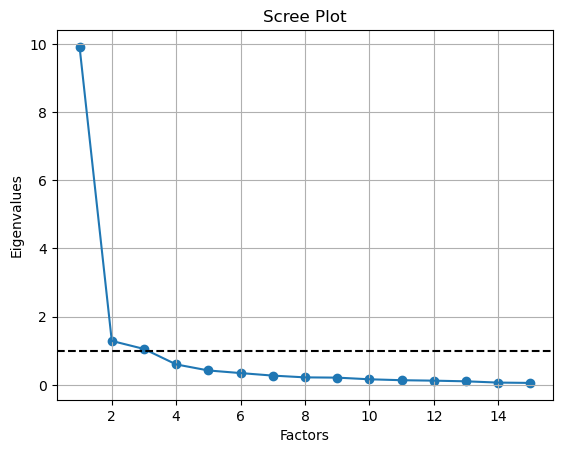

In [1721]:
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, linestyle='--', color='black')
plt.grid()
plt.show()

In [1722]:
alpha = cronbach_alpha(data=df)
alpha

(0.9408700231973299, array([0.94 , 0.942]))

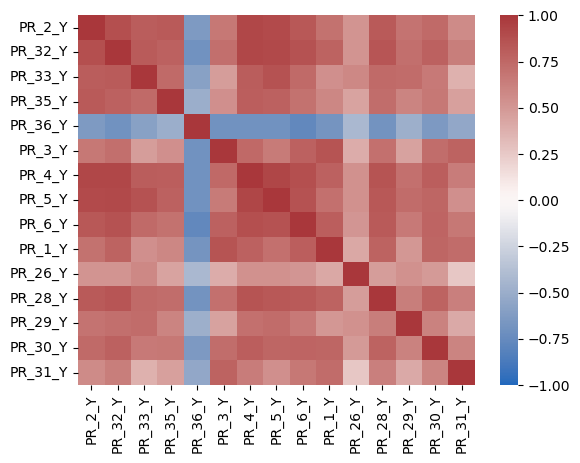

In [1723]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap='vlag');

In [1724]:
loadings = pd.DataFrame(fa.loadings_, columns = [f'factor_{i+1}' for i in range(n_factors)], index = [df.columns])
loadings

,factor_1,factor_2,factor_3
PR_2_Y,0.892910,0.009135,0.062581
PR_32_Y,0.816106,0.145388,0.043605
PR_33_Y,0.902034,-0.312429,0.291565
PR_35_Y,0.800587,-0.074537,0.108862
PR_36_Y,-0.523224,-0.390098,0.111395
PR_3_Y,0.363560,0.784623,-0.291012
PR_4_Y,0.848029,0.158226,0.008721
PR_5_Y,0.921519,-0.025982,0.093230
PR_6_Y,0.716301,0.337394,-0.073667
PR_1_Y,-0.091618,0.837035,0.228740


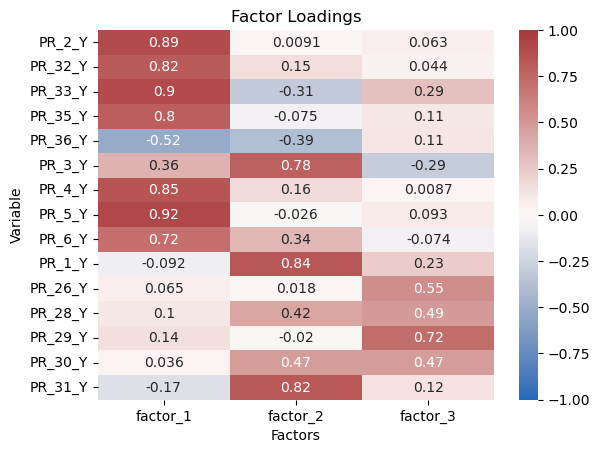

In [1725]:
sns.heatmap(loadings, vmin=-1, vmax=1, annot=True, cmap='vlag')
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Factor Loadings');

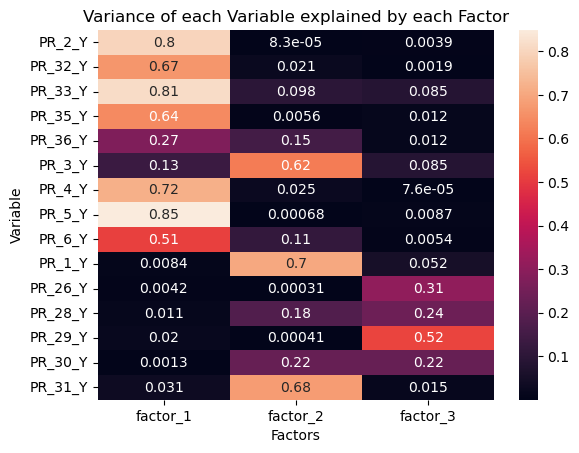

In [1726]:
sns.heatmap(loadings.apply(lambda x: x**2), annot=True)
plt.xlabel('Factors')
plt.ylabel('Variable')
plt.title('Variance of each Variable explained by each Factor');

In [1727]:
factor_var = pd.DataFrame(fa.get_factor_variance(), columns = [f'factor_{i+1}' for i in range(n_factors)], index=['variance', 
                                                                                                          'proportional_variance', 'cumulative_variance'])
factor_var

,factor_1,factor_2,factor_3
variance,5.480328,2.816958,1.565989
proportional_variance,0.365355,0.187797,0.104399
cumulative_variance,0.365355,0.553152,0.657552


In [1728]:
df.isna().any()

PR_2_Y     True
PR_32_Y    True
PR_33_Y    True
PR_35_Y    True
PR_36_Y    True
PR_3_Y     True
PR_4_Y     True
PR_5_Y     True
PR_6_Y     True
PR_1_Y     True
PR_26_Y    True
PR_28_Y    True
PR_29_Y    True
PR_30_Y    True
PR_31_Y    True
dtype: bool

In [1729]:
df = df[(~df['PR_2_Y'].isna()) & 
    (~df['PR_3_Y'].isna()) &
    (~df['PR_4_Y'].isna()) &
    (~df['PR_32_Y'].isna()) &
    (~df['PR_35_Y'].isna()) &
    (~df['PR_26_Y'].isna()) &
    (~df['PR_1_Y'].isna()) &
    (~df['PR_30_Y'].isna()) &
    (~df['PR_26_Y'].isna())]

In [1730]:
df.shape

(18014, 15)

In [1731]:
data = data.fillna(0)

In [1732]:
cppi = pd.DataFrame(fa.transform(df), columns=[f'factor_{i+1}' for i in range(n_factors)], index = df.index)
cppi

,factor_1,factor_2,factor_3
SVPREC_KEY,,,
06001200100,1.553728,2.666201,0.120808
06001200200,1.637041,2.561408,0.299828
06001201400,1.974362,2.610961,0.615319
06001202200,2.267331,2.244958,1.250240
06001202500,2.320254,2.123347,1.922586
...,...,...,...
060395141,-1.216347,-1.457799,-0.742845
060395160,-0.817544,-1.314831,-0.460589
060395183,-0.352214,-0.877208,-0.544493


<Axes: >

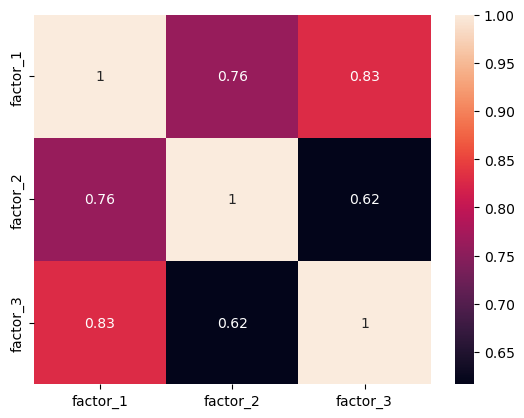

In [1733]:
# Correlation between factors
sns.heatmap(cppi.corr(), annot=True)

In [1734]:
cppi['factor_1'].mean(), cppi['factor_1'].std(), cppi['factor_1'].min(), cppi['factor_1'].max()

(-0.00584523152952566,
 1.0406519952660642,
 -3.984169383776231,
 4.104834617763606)

In [1735]:
cppi['factor_2'].mean(), cppi['factor_2'].std(), cppi['factor_2'].min(), cppi['factor_2'].max()

(0.032221100679884984,
 0.9700247731208045,
 -4.006875756127301,
 3.041311218981957)

In [1736]:
cppi['factor_3'].mean(), cppi['factor_3'].std(), cppi['factor_3'].min(), cppi['factor_3'].max()

(0.04557206052749858,
 0.8405575821927687,
 -4.664846443132778,
 5.327220965734573)

In [1737]:
# # conditional on only using factor 1
# cppi['cppi'] = (cppi['factor_1'] - cppi['factor_1'].min()) / (cppi['factor_1'].max() - cppi['factor_1'].min())
# cppi

In [1738]:
cppi['cppi'] = cppi['factor_1'] + cppi['factor_2'] + cppi['factor_3']
cppi['cppi_unstd'] = cppi['cppi']
cppi['cppi'] = (cppi['cppi'] - cppi['cppi'].min()) / (cppi['cppi'].max() - cppi['cppi'].min())
cppi

,factor_1,factor_2,factor_3,cppi,cppi_unstd
SVPREC_KEY,,,,,
06001200100,1.553728,2.666201,0.120808,0.761259,4.340737
06001200200,1.637041,2.561408,0.299828,0.769135,4.498278
06001201400,1.974362,2.610961,0.615319,0.804249,5.200641
06001202200,2.267331,2.244958,1.250240,0.832340,5.762528
06001202500,2.320254,2.123347,1.922586,0.862520,6.366187
...,...,...,...,...,...
060395141,-1.216347,-1.457799,-0.742845,0.373417,-3.416991
060395160,-0.817544,-1.314831,-0.460589,0.414614,-2.592965
060395183,-0.352214,-0.877208,-0.544493,0.455561,-1.773915


In [1764]:
cppi['cppi'].min(), cppi['cppi'].max(), cppi['cppi'].mean(), cppi['cppi'].std()

(0.0, 1.0, 0.547844033522544, 0.12963580927167723)

In [1784]:
cppi['fips'] = cppi.index.map(lambda x: x[:5])
cppi.head()

,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips
SVPREC_KEY,,,,,,
06001200100,1.553728,2.666201,0.120808,0.761259,4.340737,06001
06001200200,1.637041,2.561408,0.299828,0.769135,4.498278,06001
06001201400,1.974362,2.610961,0.615319,0.804249,5.200641,06001
06001202200,2.267331,2.244958,1.250240,0.832340,5.762528,06001
06001202500,2.320254,2.123347,1.922586,0.862520,6.366187,06001


In [1786]:
cppi_full = pd.merge(left=cppi.reset_index(), right=full_data, left_on='SVPREC_KEY', right_on='SRPREC_KEY', how='inner')
cppi_full.head()

,SVPREC_KEY,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips,SRPREC_KEY,PR_1_N,PR_1_Y,...,PRSLIB01,PRSPAF01,SENDEM01,SENDEM02,SENREP01,SENREP02,USPDEM01,USPREP01,USSDEM01,USSREP01
0,06001200100,1.553728,2.666201,0.120808,0.761259,4.340737,06001,06001200100,110.394301,2391.379349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06001200200,1.637041,2.561408,0.299828,0.769135,4.498278,06001,06001200200,84.131590,1476.736304,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06001201400,1.974362,2.610961,0.615319,0.804249,5.200641,06001,06001201400,103.578871,2247.796796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06001202200,2.267331,2.244958,1.250240,0.832340,5.762528,06001,06001202200,23.911917,251.075125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06001202500,2.320254,2.123347,1.922586,0.862520,6.366187,06001,06001202500,21.736580,229.559095,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1788]:
# EDA
cnty_cppi = cppi.groupby(['fips'])['factor_1'].agg(['median'])# .sort_values(['median'], ascending=False)
cnty_cppi

,median
fips,
06001,0.857312
06003,0.663195
06005,-1.264311
06007,-0.478405
06009,-1.348704
06011,-1.413517
06013,0.227195
06015,-0.585347
06017,-1.251882


In [1790]:
cnty_f1 = {}
cnty_f2 = {}
cnty_cppi = {}

# cnty_f3 = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_f1 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_1'].map(lambda x: x + abs(cnty_df['factor_1'].min()))) - abs(cnty_df['factor_1'].min())
    weighted_avg_f2 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_2'].map(lambda x: x + abs(cnty_df['factor_2'].min()))) - abs(cnty_df['factor_2'].min())
    weighted_avg_cppi = np.sum(cnty_df['G24PTot'] * cnty_df['cppi'])
    cnty_f1.update({i: weighted_avg_f1})
    cnty_f2.update({i: weighted_avg_f2})
    cnty_cppi.update({i: weighted_avg_cppi})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_cppi

{'06001': 0.6887544854039682,
 '06003': 0.6462079308370863,
 '06005': 0.398381191702374,
 '06007': 0.5069413608235511,
 '06009': 0.40289718833454347,
 '06011': 0.40502220709811904,
 '06013': 0.6141793612669966,
 '06015': 0.4570270736937511,
 '06017': 0.4368588500115934,
 '06019': 0.48520491456399684,
 '06021': 0.3810033022934223,
 '06023': 0.6242582947031409,
 '06025': 0.575023773535075,
 '06027': 0.49062988800576385,
 '06029': 0.45722947008547643,
 '06031': 0.44500557043853867,
 '06033': 0.5206546376463436,
 '06035': 0.34305265163805043,
 '06037': 0.6194197525151073,
 '06039': 0.0,
 '06041': 0.6566781822133146,
 '06043': 0.4304929926707136,
 '06045': 0.6068514572574272,
 '06047': 0.5172814938810644,
 '06049': 0.34020478389905057,
 '06051': 0.5814607026195544,
 '06053': 0.6245261539374782,
 '06055': 0.5829747809194414,
 '06057': 0.5285086492078143,
 '06059': 0.5045320464222192,
 '06061': 0.4415439921630998,
 '06063': 0.4377266437667019,
 '06065': 0.5130977119304083,
 '06067': 0.5739997

In [1792]:
cnty_f1 = pd.DataFrame(cnty_f1, index=[0]).T.reset_index().rename({'index': 'fips', 0: 'avg_f1'}, axis=1)
cnty_f2 = pd.DataFrame(cnty_f2, index=[1]).T.reset_index().rename({'index': 'fips', 1: 'avg_f2'}, axis=1)
cnty_cppi = pd.DataFrame(cnty_cppi, index=[2]).T.reset_index().rename({'index': 'fips', 2: 'cppi'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f1, on='fips', how='inner')
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f2, on='fips', how='inner')
#cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_f3, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2
0,06001,0.688754,0.975065,1.262910
1,06003,0.646208,0.503518,0.848803
2,06005,0.398381,-1.206065,-0.881628
3,06007,0.506941,-0.322608,-0.238122
4,06009,0.402897,-1.230753,-0.836940


In [1794]:
def getCounties():
    "Function to return a dict of FIPS codes (keys) of U.S. counties (values)"
    d = {}
    r = requests.get("http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt")
    reader = csv.reader(r.text.splitlines(), delimiter=',')    
    for line in reader:
        d[line[1] + line[2]] = line[3].replace(" County","")    
    return d

cnty_df = pd.DataFrame(getCounties(), index=[0]).T.reset_index().rename({'index': 'fips', 0:'cnty_name'}, axis=1)
cnty_df.head()

,fips,cnty_name
0,01001,Autauga
1,01003,Baldwin
2,01005,Barbour
3,01007,Bibb
4,01009,Blount


In [1796]:
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_df, on='fips', how='inner')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name
0,06001,0.688754,0.975065,1.262910,Alameda
1,06003,0.646208,0.503518,0.848803,Alpine
2,06005,0.398381,-1.206065,-0.881628,Amador
3,06007,0.506941,-0.322608,-0.238122,Butte
4,06009,0.402897,-1.230753,-0.836940,Calaveras


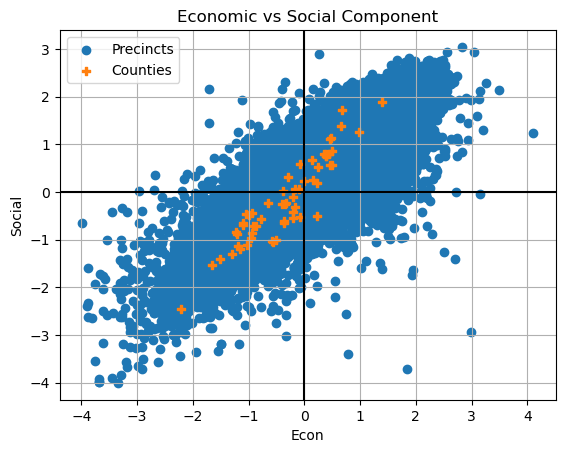

In [1798]:
plt.scatter(cppi['factor_1'], cppi['factor_2'], label='Precincts')
plt.scatter(cnty_cppi['avg_f1'], cnty_cppi['avg_f2'], marker='P', label='Counties')
plt.xlabel('Econ')
plt.ylabel('Social')
plt.title('Economic vs Social Component')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.grid()
plt.legend();

In [1800]:
cppi_full.columns.values

array(['SVPREC_KEY', 'factor_1', 'factor_2', 'factor_3', 'cppi',
       'cppi_unstd', 'fips', 'SRPREC_KEY', 'PR_1_N', 'PR_1_Y', 'PR_26_N',
       'PR_26_Y', 'PR_27_N', 'PR_27_Y', 'PR_28_N', 'PR_28_Y', 'PR_29_N',
       'PR_29_Y', 'PR_30_N', 'PR_30_Y', 'PR_31_N', 'PR_31_Y', 'PR_1_TOT',
       'PR_26_TOT', 'PR_27_TOT', 'PR_28_TOT', 'PR_29_TOT', 'PR_30_TOT',
       'PR_31_TOT', 'SRPREC', 'COUNTY', 'FIPS_CODE', 'G24PDem', 'G24PRep',
       'G24POth', 'G24PTot', 'G24SDem', 'G24SRep', 'G24STot', 'G24SSDem',
       'G24SSRep', 'G24SSTot', 'G24HDem', 'G24HRep', 'G24HTot',
       'G24SLDUDem', 'G24SLDURep', 'G24SLDUTot', 'G24SLDLDem',
       'G24SLDLRep', 'G24SLDLTot', 'G24PR2_N', 'G24PR2_Y', 'G24PR2_T',
       'G24PR32_N', 'G24PR32_Y', 'G24PR32_T', 'G24PR33_N', 'G24PR33_Y',
       'G24PR33_T', 'G24PR34_N', 'G24PR34_Y', 'G24PR34_T', 'G24PR35_N',
       'G24PR35_Y', 'G24PR35_T', 'G24PR36_N', 'G24PR36_Y', 'G24PR36_T',
       'G24PR3_N', 'G24PR3_Y', 'G24PR3_T', 'G24PR4_N', 'G24PR4_Y',
       'G24P

In [1802]:
cppi.columns.values

array(['factor_1', 'factor_2', 'factor_3', 'cppi', 'cppi_unstd', 'fips'],
      dtype=object)

In [1804]:
# metric = 'factor_1'
# race = 'G24PR5'

# race_tot = cppi_full[f'{race}_Y'] + cppi_full[f'{race}_N']

# model = lm.LinearRegression().fit(cppi_full[[metric]].values, (cppi_full[f'{race}_Y'] / race_tot).values)
# r = r_regression(cppi_full[[metric]], cppi_full[f'{race}_Y'] / race_tot)
# print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
# print(f'r = {r}')

# if metric == 'cppi':
#     x = np.linspace(0, 1, 10000)
# else:
#     x = np.linspace(-4, 4, 20000)

# plt.scatter(cppi_full[metric], cppi_full[f'{race}_Y'] / race_tot, alpha=0.1, s=30)
# plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
# plt.xlabel(metric)
# plt.ylabel(race)
# plt.title(f'{metric} vs {race}');

In [1812]:
cppi_full['G24PTot'] = cppi_full['G24PDem'] + cppi_full['G24PRep'] + cppi_full['G24POth']

Coefficient: [0.05749449], Intercept: 0.541537982085446
r = [0.8840005]


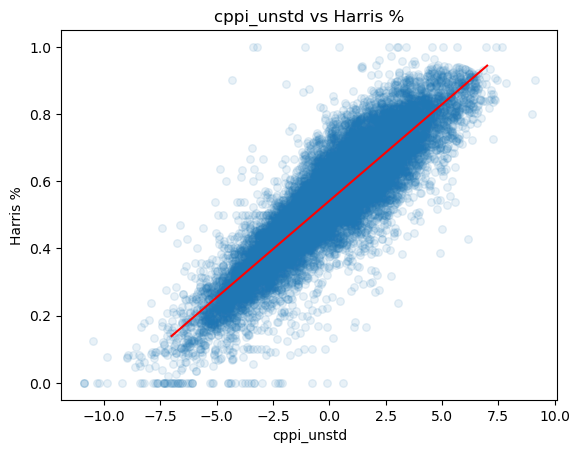

In [1814]:
metric = 'cppi_unstd'
race = 'G24PDem'

race_pct = cppi_full[race] / cppi_full['G24PTot']

model = lm.LinearRegression().fit(cppi_full[[metric]].values, race_pct.values)
r = r_regression(cppi_full[[metric]], race_pct)
print(f'Coefficient: {model.coef_}, Intercept: {model.intercept_}')
print(f'r = {r}')

if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-7, 7, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, model.coef_[0]*x + model.intercept_, color='red')
plt.xlabel(metric)
plt.ylabel('Harris %')
plt.title(f'{metric} vs Harris %');

In [1816]:
## The actual IWAR/VAIR model

In [1818]:
cppi_full['P24_margin'] = cppi_full['G24PDem'] - cppi_full['G24PRep']
metric = 'cppi_unstd'
race = 'P24_margin'

race_pct = cppi_full[race] / cppi_full['G24PTot']
cppi_full['P24_margin'] = race_pct

In [1820]:
def logistic(x, params):
    A, B, C, K, Q, v = params
    y = A + (K - A)/((C + Q*np.exp(-B*x))**(1/v))
    return y

def logistic_fixed(x, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    return logistic(x, params)

def loss_fun(x, y, B, C, Q, v):
    params = [-1, B, C, 2, Q, v]
    logistic_res = logistic(x, params)
    loss = np.sum((logistic_res - y)**2)
    return loss

In [1822]:
# x0 = [0.5, 1, 1, 1]
# params = opt.fmin(loss_fun, x0=x0)
# B, C, Q, v = params
# B, C, Q, v, loss_fun(params)

In [1824]:
X = cppi_full[[metric]]
y = race_pct
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

def kfold_cv(X_train, y_train, x0, bounds, k=5):
    kf = KFold(n_splits=k)
    losses = []
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        X_fold_train, y_fold_train, X_val, y_val = X_train[metric].values[train_index], y_train.values[train_index], X_train[metric].values[test_index], y_train.values[test_index]
        params, cov = opt.curve_fit(logistic_fixed, X_fold_train, y_fold_train, p0=x0, bounds=bounds)
        B, C, Q, v = params
        val_loss = loss_fun(X_val, y_val, B, C, Q, v)
        losses.append(val_loss)
    return losses 

In [1826]:
x0 = [0.5, 1, 1, 1]
bounds = ([-np.inf, -np.inf, -np.inf, 0], np.inf)
kfold_losses = kfold_cv(X_train, y_train, x0=x0, bounds=bounds, k=5)
print(f'K-Fold CV L2 losses: {kfold_losses}')

params, cov = opt.curve_fit(logistic_fixed, X_train[metric], y_train, p0=x0, bounds=bounds, full_output=False)
B, C, Q, v = params
print(f'B = {B}, C = {C}, Q = {Q}, v = {v}')
print(f'Training set loss: {loss_fun(X_train[metric], y_train, B, C, Q, v)},\n test set loss: {loss_fun(X_test[metric], y_test, B, C, Q, v)}')
print(f'Total loss: {loss_fun(X[metric], y, B, C, Q, v)}')

K-Fold CV L2 losses: [65.92710022135954, 57.32888406467176, 60.65777931089143, 59.07784413914452, 53.20237836767873]
B = 0.16683104006145807, C = 1.0000376797247776, Q = 7.303899449576384e-05, v = 0.00011371661181141905
Training set loss: 295.9660716466117,
 test set loss: 141.5585452453209
Total loss: 437.52461689193257


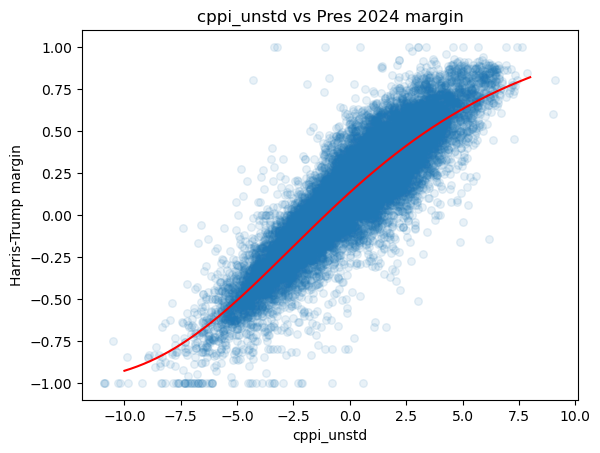

In [1828]:
if metric == 'cppi':
    x = np.linspace(0, 1, 10000)
elif metric == 'cppi_unstd':
    x = np.linspace(-10, 8, 20000)
else:
    x = np.linspace(-4, 4, 20000)

plt.scatter(cppi_full[metric], race_pct, alpha=0.1, s=30)
plt.plot(x, logistic_fixed(x, B, C, Q, v), color='red')
plt.xlabel(metric)
plt.ylabel('Harris-Trump margin')
plt.title(f'{metric} vs Pres 2024 margin');

In [1830]:
logistic(0, [-1, B, C, 2, Q, v])

0.1331813397119137

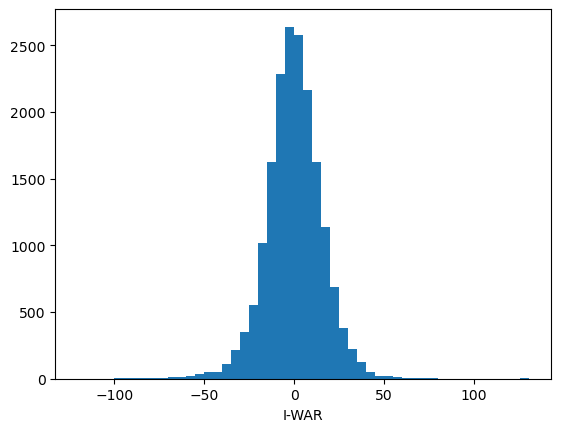

In [1832]:
# We can create a sort of Harris ideological WAR (I-WAR) metric based on this
pred_margin = logistic(cppi_full[metric], [-1, B, C, 2, Q, v])
cppi_full['iwar'] = (cppi_full['P24_margin'] - pred_margin) * 100
cppi = pd.merge(left=cppi.reset_index(), right=cppi_full[['SVPREC_KEY', 'iwar']], on='SVPREC_KEY').set_index(['SVPREC_KEY'])
plt.hist(cppi_full['iwar'], bins=50)
plt.xlabel('I-WAR');

In [1834]:
cppi_full['iwar']

0        28.222375
1        26.158218
2        22.594658
3        10.200943
4        -1.849641
           ...    
18009    -2.109432
18010   -17.324952
18011   -17.303813
18012   -25.488693
18013    -1.101679
Name: iwar, Length: 18014, dtype: float64

In [1836]:
cnty_iwar = {}

for i in np.unique(cppi['fips'].values):
    cnty_df = cppi_full[cppi_full['fips'] == i]
    cnty_df['G24PTot'] = cnty_df['G24PTot'] / cnty_df['G24PTot'].sum()
    weighted_avg_iwar = np.sum(cnty_df['G24PTot'] * cnty_df['iwar'])
    cnty_iwar.update({i: weighted_avg_iwar})
    #weighted_avg_f3 = np.sum(cnty_df['G24PTot'] * cnty_df['factor_3'].map(lambda x: x + abs(cnty_df['factor_3'].min()))) - abs(cnty_df['factor_3'].min())
    #cnty_f3.update({i: weighted_avg_f3})

cnty_iwar

{'06001': 10.740875567841162,
 '06003': -3.939918058881983,
 '06005': -3.6357869163002654,
 '06007': -5.541441879037888,
 '06009': -5.094953989661377,
 '06011': -5.782963835934398,
 '06013': 9.642542381563691,
 '06015': -7.215778254818506,
 '06017': 2.672146667182283,
 '06019': -1.9434237197543496,
 '06021': -6.402905660106101,
 '06023': -1.3473602587766988,
 '06025': -20.117077554963252,
 '06027': -2.317075498752148,
 '06029': -11.481057198709617,
 '06031': -10.830166403105995,
 '06033': -8.603024006669473,
 '06035': -15.785447220683688,
 '06037': 4.113530731724948,
 '06039': -6.223877920398712,
 '06041': 25.89574250205727,
 '06043': -4.343694045692175,
 '06045': 0.15578419688705902,
 '06047': -9.615774905878123,
 '06049': -7.591234001604416,
 '06051': -0.7501623775514203,
 '06053': -0.8312587863678416,
 '06055': 13.036769459346218,
 '06057': 3.9462326978299322,
 '06059': 0.08745333873119998,
 '06061': 4.573704851677816,
 '06063': -2.934184977275106,
 '06065': -5.893511398125192,
 '06

In [1838]:
cnty_iwar = pd.DataFrame(cnty_iwar, index=[3]).T.reset_index().rename({'index': 'fips', 3: 'iwar'}, axis=1)
cnty_cppi = pd.merge(left=cnty_cppi, right=cnty_iwar, on='fips')
cnty_cppi.head()

,fips,cppi,avg_f1,avg_f2,cnty_name,iwar
0,06001,0.688754,0.975065,1.262910,Alameda,10.740876
1,06003,0.646208,0.503518,0.848803,Alpine,-3.939918
2,06005,0.398381,-1.206065,-0.881628,Amador,-3.635787
3,06007,0.506941,-0.322608,-0.238122,Butte,-5.541442
4,06009,0.402897,-1.230753,-0.836940,Calaveras,-5.094954


In [1840]:
cppi.head()

,factor_1,factor_2,factor_3,cppi,cppi_unstd,fips,iwar
SVPREC_KEY,,,,,,,
06001200100,1.553728,2.666201,0.120808,0.761259,4.340737,06001,28.222375
06001200200,1.637041,2.561408,0.299828,0.769135,4.498278,06001,26.158218
06001201400,1.974362,2.610961,0.615319,0.804249,5.200641,06001,22.594658
06001202200,2.267331,2.244958,1.250240,0.832340,5.762528,06001,10.200943
06001202500,2.320254,2.123347,1.922586,0.862520,6.366187,06001,-1.849641


In [1842]:
df.columns

Index(['PR_2_Y', 'PR_32_Y', 'PR_33_Y', 'PR_35_Y', 'PR_36_Y', 'PR_3_Y',
       'PR_4_Y', 'PR_5_Y', 'PR_6_Y', 'PR_1_Y', 'PR_26_Y', 'PR_28_Y', 'PR_29_Y',
       'PR_30_Y', 'PR_31_Y'],
      dtype='object')

In [1844]:
data.head()

,PR_2_Y,PR_32_Y,PR_33_Y,PR_34_Y,PR_35_Y,PR_36_Y,PR_3_Y,PR_4_Y,PR_5_Y,PR_6_Y,...,SENREP01,SENREP01,sen_tot,PR_1_Y,PR_26_Y,PR_27_Y,PR_28_Y,PR_29_Y,PR_30_Y,PR_31_Y
SVPREC_KEY,,,,,,,,,,,,,,,,,,,,,
06001200100,0.808414,0.747525,0.312950,0.401340,0.773941,0.478416,0.936986,0.851100,0.629434,0.754941,...,210.0,0.0,2870.0,0.955874,0.252309,0.104331,0.847685,0.350400,0.599536,0.886794
06001200200,0.803354,0.745623,0.372313,0.380798,0.757449,0.462141,0.929746,0.845148,0.653230,0.757292,...,138.0,0.0,1938.0,0.946099,0.265665,0.094828,0.844839,0.352388,0.627811,0.872772
06001201400,0.848705,0.787456,0.420717,0.384644,0.778610,0.424189,0.936925,0.874056,0.718925,0.790689,...,184.0,0.0,2884.0,0.955950,0.283810,0.106240,0.854969,0.401321,0.667172,0.878068
06001202200,0.847291,0.813602,0.590078,0.376344,0.798956,0.367609,0.911111,0.863184,0.760101,0.820051,...,35.0,0.0,390.0,0.913043,0.373188,0.178571,0.837456,0.450549,0.746528,0.794326
06001202500,0.856916,0.759740,0.647255,0.477002,0.818923,0.385484,0.910494,0.899371,0.786624,0.765189,...,80.0,0.0,617.0,0.913502,0.502915,0.230524,0.891263,0.541633,0.740191,0.824003


In [1846]:
np.unique(data.index.map(lambda x: x[:5]))

array(['06001', '06003', '06005', '06007', '06009', '06011', '06013',
       '06015', '06017', '06019', '06021', '06023', '06025', '06027',
       '06029', '06031', '06033', '06035', '06037', '06039', '06041',
       '06043', '06045', '06047', '06049', '06051', '06053', '06055',
       '06057', '06059', '06061', '06063', '06065', '06067', '06069',
       '06071', '06073', '06075', '06077', '06079', '06081', '06083',
       '06085', '06087', '06089', '06091', '06093', '06095', '06097',
       '06099', '06101', '06103', '06105', '06107', '06109', '06111',
       '06113', '06115'], dtype=object)

In [1848]:
cnty_cppi.to_csv('cnty_cppi.csv', index=False)
cppi.to_csv('cppi/cppi.csv')